# Purpose

# Imports

In [1]:
import numpy as np
import pandas as pd
import os, csv, glob
import matplotlib.pyplot as plt

In [2]:
from Bio.Blast import NCBIWWW
from Bio import SeqIO 
from Bio.Blast import NCBIXML

In [3]:
from thefuzz import fuzz

In [19]:
from itertools import compress
import multiprocessing

# Functions

In [5]:
obi_out_fld = '/home/dennislab2/Desktop/seq/'

In [6]:
file_paths = [os.path.join(obi_out_fld,file) for file in os.listdir(obi_out_fld) if 'out.csv' in file]
file_paths

['/home/dennislab2/Desktop/seq/skokholm_plant_2_7_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_6_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_2_3_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_19_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_22_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_3_3_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_2_6_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_20_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_2_24_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_3_17_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_1_15_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_3_17_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_1_12_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_2_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_3_2_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_1_20_2_out

# Use case

# Procedure

In [10]:
file = pd.read_table(file_paths[0])
file.head()

,ID_STATUS,BEST_MATCH_TAXIDS,NUC_SEQ,SCIENTIFIC_NAME,BEST_MATCH_IDS,TAXID,BEST_IDENTITY,COUNT,ID,DEFINITION,QUALITY
0,False,NaN,tgtgaattgcaggattccggcaaaggttccttttaaaggcaatgaa...,NaN,NaN,NaN,0.0,1,MN00399:137:000H5TNVJ:1:11101:4944:1117,2:N:0:TAGGAGCT,"[28, 37, 32, 32, 37, 37, 37, 37, 28, 37, 37, 3..."
1,False,NaN,tgtgaattgcagaatcccgtgaaccatcgagtctttgaacgcaagt...,NaN,NaN,NaN,0.0,1,MN00399:137:000H5TNVJ:1:11101:16101:1124,2:N:0:TAGGAGCT,"[37, 37, 32, 32, 32, 37, 37, 37, 37, 37, 37, 3..."
2,False,NaN,cccgtttgatttggggtcacataaaagaggaagtttttatgatgtg...,NaN,NaN,NaN,0.0,1,MN00399:137:000H5TNVJ:1:11101:15383:1127,2:N:0:TAGGAGCT,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
3,False,NaN,cccgtttgatttggggtcacaacgtttgtgtcgcaacaaggcaaca...,NaN,NaN,NaN,0.0,1,MN00399:137:000H5TNVJ:1:11101:14970:1131,2:N:0:TAGGAGCT,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
4,False,NaN,cccggttgatttggggtcgcacgattaatctcatctgccaaaatta...,NaN,NaN,NaN,0.0,1,MN00399:137:000H5TNVJ:1:11101:25011:1148,2:N:0:TAGGAGCT,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 14, 37, 3..."


In [11]:
file.NUC_SEQ[100]

'tgtgaattgcaggattccggacgagctgggcgacggcaccgacgccgagatcgagaagatgcgtgagacggcggccaagaaaaactggcccgcggaagtgggcgagaccttcgagaaggagttgcagaaggtcgagcggctgaaccccgc'

In [12]:
# want to get unique sequences, and then remove

In [13]:
unique_scinames = np.unique(file.SCIENTIFIC_NAME.dropna())

In [14]:
for sci_name in unique_scinames:
    print(sci_name,len(file[file.SCIENTIFIC_NAME==sci_name]))

In [15]:
all_seqs = file.NUC_SEQ.to_list()
all_seqs[0]

'tgtgaattgcaggattccggcaaaggttccttttaaaggcaatgaaagaagcatttccttccattcccgcattatatcgccggattcatccgtcacctccggattctgcgtagtcgtcacaagggccgccagaatctctcccgtcgcggc'

In [37]:
file_paths[7]

'/home/dennislab2/Desktop/seq/skokholm_plant_2_20_1_out.csv'

In [40]:
def get_ncbi(file_path):
    try:
        file = pd.read_table(file_path)
    except:
        print('{} FAILED'.format(file_path))
    all_seqs= np.array(file.NUC_SEQ)
    list_of_seqs_lens=[]
    list_of_seqs=[]
    print('starting while loop for file_path {}'.format(file_path))

    while len(all_seqs)>1:
        seq = all_seqs[0]# add a sequence
        bool_list=[]
        # get similar sequences, delete from the all_seqs list before iterating
        for i in np.arange(0,len(all_seqs)):
                    # if 97% or better match, add a number fo the n_val
                    if fuzz.ratio(seq,all_seqs[i]) >96:
                        bool_list.append(False)
                    else:
                        bool_list.append(True)
        num_of_seqs = len(bool_list) - np.sum(bool_list)
        if num_of_seqs > 15:
            list_of_seqs.append(seq)
            list_of_seqs_lens.append(num_of_seqs)
        all_seqs = list(compress(all_seqs,bool_list))
    # save out as fasta!
    # read in fasta!
    result_list = []
    seq_counter=-1
    for seq in list_of_seqs:
        seq_counter+=1
        filename_new='/home/dennislab2/Desktop/genomics/2023_skokholm/ncbi_outputs/results_{}_{}.csv'.format(file_path.split('/')[-1].split('_out.csv')[0],seq_counter)
        if os.path.isfile(filename_new):
            print('already processed seq {}, skipping'.format(seq_counter))
        else:
            print('starting blast {} of {}'.format(seq_counter,len(list_of_seqs)))
            result_handle = NCBIWWW.qblast('blastn','nt',seq)
            results_filename = "/home/dennislab2/Desktop/ncbi_outputs/results_{}_{}.xml".format(file_path.split('/')[-1].split('_out.csv')[0],seq_counter)
            data_tuples=[]
            with open(results_filename, 'w') as save_file: 
                blast_results = result_handle.read()
                save_file.write(blast_results)
            for record in NCBIXML.parse(open(results_filename)): 
                if record.alignments: 
                    for align in record.alignments: 
                        for hsp in align.hsps: 
                            if hsp.expect < 1e-10:
                                data_tuples.append((align.hit_def,align.accession,hsp.sbjct,hsp.identities,hsp.expect))
            pd.DataFrame(data_tuples,columns=['hit_definition','hit_accession','subject','identities','expect']).to_csv(filename_new)

In [43]:
file_paths

['/home/dennislab2/Desktop/seq/skokholm_plant_2_7_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_6_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_2_3_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_19_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_22_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_3_3_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_2_6_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_20_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_2_24_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_3_17_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_1_15_2_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_3_17_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_invert_1_12_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_2_2_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_3_2_1_out.csv',
 '/home/dennislab2/Desktop/seq/skokholm_plant_1_20_2_out

In [44]:
pool = multiprocessing.Pool(36)
pool.map(get_ncbi,[file for file in file_paths[1:10]])

/home/dennislab2/Desktop/seq/skokholm_invert_2_3_1_out.csv FAILED
/home/dennislab2/Desktop/seq/skokholm_plant_3_3_2_out.csv FAILED
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_plant_2_22_2_out.csv
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_invert_2_24_2_out.csv
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_plant_2_20_1_out.csv
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_invert_2_6_1_out.csv
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_plant_2_6_2_out.csv
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_plant_2_19_1_out.csv
starting while loop for file_path /home/dennislab2/Desktop/seq/skokholm_plant_3_17_2_out.csv
starting blast 0 of 106
starting blast 0 of 32
starting blast 0 of 22
already processed seq 0, skipping
already processed seq 1, skipping
already processed seq 2, skipping
already processed seq 3, skipping
already proc

Process ForkPoolWorker-397:
Process ForkPoolWorker-377:
Process ForkPoolWorker-388:
Process ForkPoolWorker-403:
Process ForkPoolWorker-409:
Process ForkPoolWorker-400:
Process ForkPoolWorker-399:
Process ForkPoolWorker-405:
Process ForkPoolWorker-404:
Process ForkPoolWorker-402:
Process ForkPoolWorker-401:
Process ForkPoolWorker-410:
Process ForkPoolWorker-408:
Process ForkPoolWorker-394:
Process ForkPoolWorker-378:
Process ForkPoolWorker-407:
Process ForkPoolWorker-383:
Process ForkPoolWorker-376:
Process ForkPoolWorker-379:
Process ForkPoolWorker-406:
Process ForkPoolWorker-382:
Process ForkPoolWorker-381:
Process ForkPoolWorker-398:
Traceback (most recent call last):
Process ForkPoolWorker-375:
Process ForkPoolWorker-390:
Process ForkPoolWorker-380:
Process ForkPoolWorker-384:
Process ForkPoolWorker-385:
Process ForkPoolWorker-391:
Process ForkPoolWorker-393:
Traceback (most recent call last):
Process ForkPoolWorker-392:
Traceback (most recent call last):
Traceback (most recent call

  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/l

KeyboardInterrupt: 

  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 

  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
           ^^^^^^^^^^^^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/m

  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_108473/1803482285.py", line 37, in get_ncbi
    result_handle = NCBIWWW.qblast('blastn','nt',seq)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/site-packages/Bio/Blast/NCBIWWW.py", line 246, in qblast
    time.sleep(wait)
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dennislab2/mambaforge/envs/fieldwork/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/dennislab2/

In [120]:


for file_path in file_paths[27:47]:
    file = pd.read_table(file_path)
    all_seqs= np.array(file.NUC_SEQ)
    list_of_seqs_lens=[]
    list_of_seqs=[]
    print('starting while loop for file_path {}'.format(file_path))

    while len(all_seqs)>1:
        seq = all_seqs[0]# add a sequence
        bool_list=[]
        # get similar sequences, delete from the all_seqs list before iterating
        for i in np.arange(0,len(all_seqs)):
                    # if 97% or better match, add a number fo the n_val
                    if fuzz.ratio(seq,all_seqs[i]) >96:
                        bool_list.append(False)
                    else:
                        bool_list.append(True)
        num_of_seqs = len(bool_list) - np.sum(bool_list)
        if num_of_seqs > 15:
            list_of_seqs.append(seq)
            list_of_seqs_lens.append(num_of_seqs)
        all_seqs = all_seqs[bool_list]
    # save out as fasta!
    # read in fasta!
    result_list = []
    seq_counter=-1
    for seq in list_of_seqs:
        seq_counter+=1
        print('starting blast {} of {}'.format(seq_counter,len(list_of_seqs)))
        result_handle = NCBIWWW.qblast('blastn','nt',seq)
        results_filename = "/home/dennislab2/Desktop/ncbi_outputs/results_{}_{}.xml".format(file_path.split('/')[-1].split('_out.csv')[0],seq_counter)
        data_tuples=[]
        with open(results_filename, 'w') as save_file: 
            blast_results = result_handle.read()
            save_file.write(blast_results)
        for record in NCBIXML.parse(open(results_filename)): 
            if record.alignments: 
                for align in record.alignments: 
                    for hsp in align.hsps: 
                        if hsp.expect < 1e-10:
                            data_tuples.append((align.hit_def,align.accession,hsp.sbjct,hsp.identities,hsp.expect))
        pd.DataFrame(data_tuples,columns=['hit_definition','hit_accession','subject','identities','expect']).to_csv('/home/dennislab2/Desktop/ncbi_outputs/results_{}_{}.csv'.format(file_path.split('/')[-1].split('_out.csv')[0],seq_counter))

starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate1_12s_47_2_out.csv
starting blast 0 of 22
starting blast 1 of 22
starting blast 2 of 22
starting blast 3 of 22
starting blast 4 of 22
starting blast 5 of 22
starting blast 6 of 22
starting blast 7 of 22
starting blast 8 of 22
starting blast 9 of 22
starting blast 10 of 22
starting blast 11 of 22
starting blast 12 of 22
starting blast 13 of 22
starting blast 14 of 22
starting blast 15 of 22
starting blast 16 of 22
starting blast 17 of 22
starting blast 18 of 22
starting blast 19 of 22
starting blast 20 of 22
starting blast 21 of 22
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate1_12s_18_2_out.csv
starting blast 0 of 13
starting blast 1 of 13
starting blast 2 of 13
starting blast 3 of 13
starting blast 4 of 13
starting blast 5 of 13
starting blast 6 of 13
starting blast 7 of 13
starting blast 8 of 13
starting blast 9 of 13
starting blast 10 of 13
starting blast 11 of 13
starting blast 12 

starting blast 30 of 62
starting blast 31 of 62
starting blast 32 of 62
starting blast 33 of 62
starting blast 34 of 62
starting blast 35 of 62
starting blast 36 of 62
starting blast 37 of 62
starting blast 38 of 62
starting blast 39 of 62
starting blast 40 of 62
starting blast 41 of 62
starting blast 42 of 62
starting blast 43 of 62
starting blast 44 of 62
starting blast 45 of 62
starting blast 46 of 62
starting blast 47 of 62
starting blast 48 of 62
starting blast 49 of 62
starting blast 50 of 62
starting blast 51 of 62
starting blast 52 of 62
starting blast 53 of 62
starting blast 54 of 62
starting blast 55 of 62
starting blast 56 of 62
starting blast 57 of 62
starting blast 58 of 62
starting blast 59 of 62
starting blast 60 of 62
starting blast 61 of 62
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate23_12s_23_2_out.csv
starting blast 0 of 38
starting blast 1 of 38
starting blast 2 of 38
starting blast 3 of 38
starting blast 4 of 38
starting blast 5 of 38


starting blast 32 of 48
starting blast 33 of 48
starting blast 34 of 48
starting blast 35 of 48
starting blast 36 of 48
starting blast 37 of 48
starting blast 38 of 48
starting blast 39 of 48
starting blast 40 of 48
starting blast 41 of 48
starting blast 42 of 48
starting blast 43 of 48
starting blast 44 of 48
starting blast 45 of 48
starting blast 46 of 48
starting blast 47 of 48
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate23_12s_11_1_out.csv
starting blast 0 of 9
starting blast 1 of 9
starting blast 2 of 9
starting blast 3 of 9
starting blast 4 of 9
starting blast 5 of 9
starting blast 6 of 9
starting blast 7 of 9
starting blast 8 of 9
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate1_12s_38_2_out.csv
starting blast 0 of 6
starting blast 1 of 6
starting blast 2 of 6
starting blast 3 of 6
starting blast 4 of 6
starting blast 5 of 6
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate1_12s_39_1_out.csv
starti

starting blast 78 of 95
starting blast 79 of 95
starting blast 80 of 95
starting blast 81 of 95
starting blast 82 of 95
starting blast 83 of 95
starting blast 84 of 95
starting blast 85 of 95
starting blast 86 of 95
starting blast 87 of 95
starting blast 88 of 95
starting blast 89 of 95
starting blast 90 of 95
starting blast 91 of 95
starting blast 92 of 95
starting blast 93 of 95
starting blast 94 of 95
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate23_12s_52_1_out.csv
starting blast 0 of 5
starting blast 1 of 5
starting blast 2 of 5
starting blast 3 of 5
starting blast 4 of 5
starting while loop for file_path /home/dennislab2/Desktop/reads_out/plate1_12s_15_2_out.csv
starting blast 0 of 19
starting blast 1 of 19
starting blast 2 of 19
starting blast 3 of 19
starting blast 4 of 19
starting blast 5 of 19
starting blast 6 of 19
starting blast 7 of 19
starting blast 8 of 19
starting blast 9 of 19
starting blast 10 of 19
starting blast 11 of 19
starting blast 12

starting blast 0 of 89
starting blast 1 of 89
starting blast 2 of 89
starting blast 3 of 89
starting blast 4 of 89
starting blast 5 of 89
starting blast 6 of 89
starting blast 7 of 89
starting blast 8 of 89
starting blast 9 of 89
starting blast 10 of 89
starting blast 11 of 89
starting blast 12 of 89
starting blast 13 of 89
starting blast 14 of 89
starting blast 15 of 89
starting blast 16 of 89
starting blast 17 of 89
starting blast 18 of 89
starting blast 19 of 89
starting blast 20 of 89
starting blast 21 of 89
starting blast 22 of 89
starting blast 23 of 89
starting blast 24 of 89
starting blast 25 of 89
starting blast 26 of 89
starting blast 27 of 89
starting blast 28 of 89
starting blast 29 of 89
starting blast 30 of 89
starting blast 31 of 89
starting blast 32 of 89
starting blast 33 of 89
starting blast 34 of 89
starting blast 35 of 89
starting blast 36 of 89
starting blast 37 of 89
starting blast 38 of 89
starting blast 39 of 89
starting blast 40 of 89
starting blast 41 of 89
st

KeyboardInterrupt: 

In [51]:
file_path = file_paths[0]


'plate1_12s_47_2'

In [58]:
result_handle = NCBIWWW.qblast('blastn','nt',seq)

In [59]:
# add seq num/id
results_filename = "results_{}.xml".format(file_path.split('/')[-1].split('_out.csv')[0])
with open(results_filename, 'w') as save_file: 
    blast_results = result_handle.read()
    save_file.write(blast_results)

In [100]:
for record in NCBIXML.parse(open(results_filename)): 
    if record.alignments: 
        print("\n") 
        for align in record.alignments: 
            for hsp in align.hsps: 
                print("%s" % align.title[:100].split('|'))



['gi', '2461860460', 'dbj', 'AB092593.1', ' Mus musculus domesticus mitochondrial DNA, complete genome, strain:C57']
['gi', '2461860446', 'dbj', 'AB092592.1', ' Mus musculus domesticus mitochondrial DNA, complete genome, strain:C57']
['gi', '2452958533', 'emb', 'OX439034.1', ' Mus musculus genome assembly, organelle: mitochondrion']
['gi', '2415280279', 'emb', 'OX390165.1', ' Mus musculus genome assembly, organelle: mitochondrion']
['gi', '2415279407', 'emb', 'OX389814.1', ' Mus musculus genome assembly, organelle: mitochondrion']
['gi', '2327616453', 'gb', 'OM948981.1', ' Mus musculus strain C57BL/6NCrl mitochondrion, complete genome']
['gi', '2282749014', 'gb', 'MZ661208.1', ' Mus musculus domesticus voucher CSCF-MAM-1571089 12S ribosomal RNA gene']
['gi', '2259040164', 'emb', 'OW971803.1', ' Mus musculus genome assembly, organelle: mitochondrion']
['gi', '2259034981', 'emb', 'OW971782.1', ' Mus musculus musculus genome assembly, organelle: mitochondrion']
['gi', '2259022775', 'emb

In [118]:
print(align.accession)
print(align.hit_def)

LC552884
Mus musculus HS4411 mitochondrial DNA, complete genome


In [107]:
x=[]
x.append((hsp.query,hsp.sbjct,hsp.identities,hsp.expect))
x.append((hsp.query,hsp.sbjct,hsp.identities,hsp.expect))
pd.DataFrame(x,columns=['query','subject','identities','expect'])

,query,subject,identities,expect
0,AAACTAGGATTAGATACCCTATTATGCTTAGCCATAAACCTAAATA...,AAACTGGGATTAGATACCCCACTATGCTTAGCCATAAACCTAAATA...,143,1.024950e-59
1,AAACTAGGATTAGATACCCTATTATGCTTAGCCATAAACCTAAATA...,AAACTGGGATTAGATACCCCACTATGCTTAGCCATAAACCTAAATA...,143,1.024950e-59


In [93]:
print(hsp.align_length)
print(hsp.bits)
print(hsp.expect)
print(hsp.identities)
print(hsp.query)
print(hsp.sbjct)
print(hsp.score)
(hsp.query,hsp.subject,hsp.identities,hsp.expect)

149
243.839
1.02495e-59
143
AAACTAGGATTAGATACCCTATTATGCTTAGCCATAAACCTAAATAATTAAATTTAACGAAACTATTTGCCAGAGAACTACTAGCCATANCTTAAAACTCAAAGGACTTGGCGATACTTTATATCCATCTAGAGGAGCCTGTTCTATAA
AAACTGGGATTAGATACCCCACTATGCTTAGCCATAAACCTAAATAATTAAATTTAACAAAACTATTTGCCAGAGAACTACTAGCCATAGCTTAAAACTCAAAGGACTTGGCGGTACTTTATATCCATCTAGAGGAGCCTGTTCTATAA
269.0


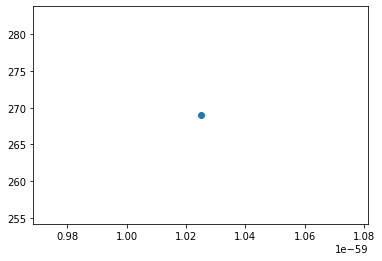

In [94]:
scores=[]
es = []
for hsp in align.hsps:
    es.append(hsp.expect)
    scores.append(hsp.score)
    

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

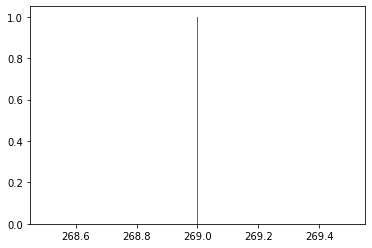

In [99]:
plt.hist(scores,bins=1000)

In [ ]:
# query cover > 70%
# e value?
# per. ident
# scientific name

## for BLAST
https://www.tutorialspoint.com/biopython/biopython_overview_of_blast.htm

- make a fasta file for each *un-identified* sequence
- load a fasta file for each *un-identified* sequence

`seq_record = next(SeqIO.parse(open('blast_example.fasta'),'fasta')) `

- blast it 
    - n blast n
    - n blast p

`result_handle = NCBIWWW.qblast("blastn", "nt", sequence_data)`


```
with open('results.xml', 'w') as save_file: 
    blast_results = result_handle.read()
    save_file.write(blast_results)
```     
- open file

```E_VALUE_THRESH = 1e-20 
for record in NCBIXML.parse(open("results.xml")): 
    if record.alignments: 
       print("\n") 
       print("query: %s" % record.query[:100]) 
       for align in record.alignments: 
          for hsp in align.hsps: 
             if hsp.expect < E_VALUE_THRESH: 
                print("match: %s " % align.title[:100])
```

In [146]:
file_nm='plate23_12s_26_1_out.csv'
df=pd.DataFrame(columns=col_nms)
df_seqdata=pd.DataFrame(columns=['file_nm','nuc_seq','count'])
file = pd.read_table(os.path.join(fld,file_nm))
unique_scinames = np.unique(file.SCIENTIFIC_NAME.dropna())
unique_scinames
subfile = file[file.SCIENTIFIC_NAME==unique_scinames[0]]

In [148]:
subfile

,TAXID,BEST_MATCH_IDS,COUNT,ID_STATUS,BEST_IDENTITY,NUC_SEQ,QUALITY,ID,DEFINITION,SCIENTIFIC_NAME,BEST_MATCH_TAXIDS
71,301514,['MN480464'],1,True,0.993333,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[32, 37, 37, 37, 37, 32, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:11101:19930:1334,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
241,301514,['MN480464'],1,True,0.986667,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[37, 37, 37, 37, 37, 37, 14, 32, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:11101:24825:2127,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
829,301514,['MN480464'],1,True,0.980132,tttttattttatttttaggtagtagtaaaaagaaacctaaaaaatt...,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:11101:9052:4351,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
896,301514,['MN480464'],1,True,0.986667,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:11101:5489:4600,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
1103,301514,['MN480464'],1,True,0.993333,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[37, 37, 37, 37, 32, 37, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:11101:18400:5448,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
...,...,...,...,...,...,...,...,...,...,...,...
122886,301514,['MN480464'],1,True,0.993333,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[37, 37, 37, 37, 37, 32, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:23104:21460:9148,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
124860,301514,['MN480464'],1,True,0.993333,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:23104:9425:16691,1:N:0:AGACCTAG+GCACGTAA,Homidia socia,[301514]
124919,301514,['MN480464'],1,True,0.980132,tttattttatttttaggtagtagtaaaaagaaacctaaaaaatttg...,"[37, 37, 37, 32, 37, 37, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:23104:1676:16971,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]
125124,301514,['MN480464'],1,True,0.993333,ttttattttatttttaggtagtagtaaaaagaaacctaaaaaattt...,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",MN00399:128:000H5JLCJ:1:23104:11433:17703,1:N:0:AGACCTTG+GCACGTAA,Homidia socia,[301514]


In [171]:
col_nms=['file_nm','sci_nm','count']
df=pd.DataFrame(columns=col_nms)
df_seqdata=pd.DataFrame(columns=['file_nm','nuc_seq','count'])
for file_nm in os.listdir(fld):
    print(file_nm)
    file = pd.read_table(os.path.join(fld,file_nm))
    unique_scinames = np.unique(file.SCIENTIFIC_NAME.dropna())
    list_of_vals=[]
    for sci_nm in unique_scinames:
        list_of_vals.append([file_nm,sci_nm,len(file[file.SCIENTIFIC_NAME==sci_nm])])
    df2 = pd.DataFrame(list_of_vals, columns=col_nms)
    df=df.append(df2,ignore_index=True)

plate1_12s_47_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_18_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_25_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_63_1_out.csv
plate23_12s_52_2_out.csv
plate1_12s_21_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_75_2_out.csv
plate23_12s_55_1_out.csv
plate23_12s_13_1_out.csv
plate23_12s_46_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_50_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_50_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_28_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_1_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_74_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_23_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_24_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_33_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_28_2_out.csv
plate1_12s_29_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_6_2_out.csv
plate1_12s_35_2_out.csv
plate1_12s_56_2_out.csv
plate23_12s_61_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_38_1_out.csv
plate23_12s_70_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_11_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_38_2_out.csv
plate1_12s_39_1_out.csv
plate23_12s_47_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_46_1_out.csv
plate23_12s_14_2_out.csv
plate23_12s_65_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_20_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_50_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_52_1_out.csv
plate1_12s_15_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_49_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_6_1_out.csv
plate1_12s_37_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_5_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_40_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_24_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_40_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_2_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_31_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_9_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_70_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_44_2_out.csv
plate23_12s_51_1_out.csv
plate1_12s_16_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_53_1_out.csv
plate23_12s_39_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_2_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_48_2_out.csv
plate1_12s_33_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_4_1_out.csv
plate23_12s_47_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_7_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_60_1_out.csv
plate23_12s_51_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_48_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_28_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_55_2_out.csv
plate1_12s_19_2_out.csv
plate1_12s_23_2_out.csv
plate23_12s_10_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_30_1_out.csv
plate23_12s_40_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_1_1_out.csv


/tmp/ipykernel_681725/2269263605.py:6: DtypeWarning: Columns (2,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_table(os.path.join(fld,file_nm))
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_14_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_19_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_13_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_58_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_36_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_55_1_out.csv
plate23_12s_69_1_out.csv
plate23_12s_4_2_out.csv
plate1_12s_18_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_43_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_56_1_out.csv
plate1_12s_21_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_41_2_out.csv
plate1_12s_17_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_49_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_31_1_out.csv
plate23_12s_75_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_68_1_out.csv
plate1_12s_23_1_out.csv
plate1_12s_22_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_27_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_41_1_out.csv
plate23_12s_31_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_37_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_20_1_out.csv
plate23_12s_60_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_15_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_53_2_out.csv
plate1_12s_5_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_67_2_out.csv
plate23_12s_19_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_32_2_out.csv
plate23_12s_33_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_32_1_out.csv
plate23_12s_64_1_out.csv
plate23_12s_28_1_out.csv
plate1_12s_27_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_31_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_71_1_out.csv
plate1_12s_8_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_35_1_out.csv
plate23_12s_66_1_out.csv
plate23_12s_32_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_26_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_53_1_out.csv
plate23_12s_12_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_45_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_23_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_7_2_out.csv
plate23_12s_39_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_14_1_out.csv
plate1_12s_7_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_51_2_out.csv
plate23_12s_24_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_51_1_out.csv
plate1_12s_48_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_8_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_12_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_72_2_out.csv
plate23_12s_21_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_9_2_out.csv
plate23_12s_69_2_out.csv
plate1_12s_52_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_3_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_63_2_out.csv
plate1_12s_22_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_1_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_16_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_45_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_2_2_out.csv
plate23_12s_38_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_57_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_30_1_out.csv
plate23_12s_26_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_48_1_out.csv
plate1_12s_59_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_43_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_34_1_out.csv
plate1_12s_5_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_10_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_58_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_18_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_44_1_out.csv
plate23_12s_74_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_56_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_21_2_out.csv
plate23_12s_36_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_35_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_37_2_out.csv
plate23_12s_22_2_out.csv
plate23_12s_62_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_55_2_out.csv
plate1_12s_1_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_52_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_3_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_57_2_out.csv
plate1_12s_49_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_38_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_64_2_out.csv
plate1_12s_58_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_10_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_15_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_58_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_26_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_29_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_54_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_6_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_12_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_62_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_17_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_13_2_out.csv
plate23_12s_20_2_out.csv
plate23_12s_42_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_46_2_out.csv
plate23_12s_18_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_59_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_47_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_59_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_7_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_14_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_4_1_out.csv
plate1_12s_57_1_out.csv
plate1_12s_43_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_6_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_8_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_66_2_out.csv
plate23_12s_30_2_out.csv
plate1_12s_25_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_73_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_8_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_43_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_27_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_9_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_73_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_44_2_out.csv
plate1_12s_11_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_59_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_5_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_44_1_out.csv
plate23_12s_15_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_33_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_39_2_out.csv
plate1_12s_9_1_out.csv
plate1_12s_11_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_35_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_54_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_68_2_out.csv
plate1_12s_3_2_out.csv
plate23_12s_56_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_25_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_22_1_out.csv
plate23_12s_17_1_out.csv


/tmp/ipykernel_681725/2269263605.py:6: DtypeWarning: Columns (6,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_table(os.path.join(fld,file_nm))
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_71_2_out.csv
plate23_12s_25_1_out.csv


/tmp/ipykernel_681725/2269263605.py:6: DtypeWarning: Columns (1,4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_table(os.path.join(fld,file_nm))
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_29_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_24_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_10_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_30_2_out.csv
plate1_12s_34_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_34_2_out.csv
plate23_12s_37_1_out.csv
plate1_12s_42_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_40_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_13_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_3_1_out.csv
plate23_12s_65_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_36_2_out.csv
plate1_12s_54_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_29_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_20_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_45_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_27_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_46_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_50_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_4_2_out.csv
plate23_12s_32_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_17_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_72_1_out.csv
plate23_12s_57_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_36_1_out.csv
plate23_12s_67_1_out.csv
plate23_12s_11_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_34_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_42_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_12_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_26_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_53_2_out.csv
plate1_12s_42_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_16_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_19_1_out.csv
plate23_12s_49_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_2_1_out.csv
plate23_12s_41_2_out.csv
plate23_12s_41_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_45_2_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)
/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate23_12s_16_2_out.csv
plate23_12s_61_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


plate1_12s_54_1_out.csv


/tmp/ipykernel_681725/2269263605.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


In [174]:
df.sort_values('file_nm')

,file_nm,sci_nm,count
5,plate1_12s_13_1_out.csv,Gryllodes,234
11,plate1_12s_1_1_out.csv,Gryllodes,721
8,plate1_12s_22_1_out.csv,Gryllodes,1886
7,plate1_12s_22_2_out.csv,Gryllodes,1749
19,plate1_12s_24_1_out.csv,Gryllodes,395
0,plate1_12s_24_2_out.csv,Gryllodes,385
14,plate1_12s_29_1_out.csv,Gryllodes,501
1,plate1_12s_29_2_out.csv,Gryllodes,419
24,plate1_12s_42_1_out.csv,Gryllodes,82
20,plate1_12s_42_2_out.csv,Gryllodes,96


In [ ]:
col_nms=['file_nm','sci_nm','count']
df=pd.DataFrame(columns=col_nms)
df_seqdata=pd.DataFrame(columns=['file_nm','nuc_seq','count'])
for file_nm in os.listdir(fld):
    print(file_nm)
    file = pd.read_table(os.path.join(fld,file_nm))
    unique_scinames = np.unique(file.SCIENTIFIC_NAME.dropna())
    list_of_vals=[]
    for sci_nm in unique_scinames:
        list_of_vals.append([file_nm,sci_nm,len(file[file.SCIENTIFIC_NAME==sci_nm])])
    df2 = pd.DataFrame(list_of_vals, columns=col_nms)
    df=df.append(df2,ignore_index=True)

In [176]:
df.to_csv('/home/dennislab2/Desktop/summary.csv')

In [2]:
df = pd.read_csv('/Users/dennise/Desktop/summary.csv')

In [3]:
df

,Unnamed: 0,file_nm,sci_nm,count
0,0,uniplant_10_1_out.tsv,Glycine subgen. Soja,1
1,1,uniplant_10_1_out.tsv,Hordeinae,1
2,2,uniplant_10_1_out.tsv,Petrosaviidae,110
3,3,uniplant_10_1_out.tsv,Potentilla,34
4,4,uniplant_10_1_out.tsv,Potentilla simplex,18
...,...,...,...,...
503,503,uniplant_8_1_out.tsv,Triticum,107
504,504,uniplant_8_1_out.tsv,Triticum aestivum,8750
505,505,uniplant_9_1_out.tsv,Petrosaviidae,27
506,506,uniplant_9_1_out.tsv,Triticum,8


In [12]:
file.columns

Index(['BEST_MATCH_IDS', 'ID', 'BEST_IDENTITY', 'ID_STATUS', 'DEFINITION',
       'TAXID', 'SCIENTIFIC_NAME', 'QUALITY', 'NUC_SEQ', 'BEST_MATCH_TAXIDS',
       'COUNT'],
      dtype='object')

In [13]:
file

,BEST_MATCH_IDS,ID,BEST_IDENTITY,ID_STATUS,DEFINITION,TAXID,SCIENTIFIC_NAME,QUALITY,NUC_SEQ,BEST_MATCH_TAXIDS,COUNT
0,NaN,MN00399:123:000H537V2:1:11101:4877:1012,0.00000,False,1:N:0:AGCCTATN+GTTACGCA,None,NaN,"[37, 37, 37, 2, 37, 37, 32, 37, 37, 37, 37, 14...",cccntttgacttggggtcacggtcgaagnnacgtgcgcttcgtttg...,NaN,1
1,NaN,MN00399:123:000H537V2:1:11101:12055:1020,0.00000,False,1:N:0:AGCCTATN+GTTACGCA,None,NaN,"[37, 37, 37, 37, 37, 37, 32, 37, 37, 37, 37, 3...",tgtgaattgcaggatcccgcgaaccatcnngtctttgaacgcaagt...,NaN,1
2,NaN,MN00399:123:000H537V2:1:11101:21707:1025,0.00000,False,1:N:0:AGCCTATN+GTTACGCA,None,NaN,"[37, 37, 37, 37, 37, 37, 37, 37, 14, 14, 37, 3...",cccgtttgacttgaggtcgcggtcgaagcgacgtgcgcttcgtttg...,NaN,1
3,['OU343190'],MN00399:123:000H537V2:1:11101:13162:1048,0.97351,True,1:N:0:AGCCTATC+GTTACGCA,4565,Triticum aestivum,"[37, 37, 37, 14, 37, 37, 37, 37, 37, 37, 37, 3...",tgtgaattgcaggatcccgcgaaccatcgagtctttgaacgcaagt...,[4565],1
4,NaN,MN00399:123:000H537V2:1:11101:8866:1056,0.00000,False,1:N:0:AGCCTATC+GTTACGCA,None,NaN,"[32, 37, 37, 37, 37, 37, 37, 37, 37, 32, 32, 3...",cccgtttgatttggggtctcggtcgaagcgacgtgcgcttcgtttg...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
47559,NaN,MN00399:123:000H537V2:1:23104:19966:20286,0.00000,False,1:N:0:AGCCTATC+GTTACGCA,None,NaN,"[37, 37, 37, 32, 37, 37, 37, 37, 37, 37, 37, 3...",cccgtttgatttggggtcgcggtcgaagcgacgtgcgcttcgtttg...,NaN,1
47560,NaN,MN00399:123:000H537V2:1:23104:17571:20294,0.00000,False,1:N:0:AGCCTATC+GTTACACA,None,NaN,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",tgtgaattgcaggatcccgtgaaccatcgagtttttgaacgcaagt...,NaN,1
47561,NaN,MN00399:123:000H537V2:1:23104:22376:20341,0.00000,False,1:N:0:AGCCTATC+GTTACGCA,None,NaN,"[32, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",cgaagcgacgtgcgcttcgtttgttgggtcgttcaaaggtcataat...,NaN,1
47562,NaN,MN00399:123:000H537V2:1:23104:4771:20347,0.00000,False,1:N:0:AGCCTATC+GTTACGCA,None,NaN,"[37, 37, 37, 32, 37, 37, 14, 32, 37, 37, 37, 3...",cccgcctgatttggggtcgcggtcgaagcgacgtgcgcttcgtttg...,NaN,1


1